In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler

# Data Cleaning, Missing Data and Normalization

## Removing Non-Predictive Features

In [2]:
# Load the data
df_unclean = pd.read_csv('CommViolPredUnnormalizedData.csv', na_values=['?'])

In [3]:
# Removing the non-predictive features
columns_to_remove = [
    'communityname',
    'state',
    'countyCode',
    'communityCode',
    'fold',
    'Unnamed: 0'
]

# Removing potential target features
columns_to_remove += [
        'murders', 
        'murdPerPop', 
        'rapes', 
        'rapesPerPop', 
        'robberies', 
        'robbbPerPop', 
        'assaults', 
        'burglaries',
        'burglPerPop', 
        'larcenies', 
        'larcPerPop',
        'autoTheft', 
        'autoTheftPerPop', 
        'arsons', 
        'arsonsPerPop',
        'ViolentCrimesPerPop', 
        'nonViolPerPop'
    ]


df_cleaned = df_unclean.drop(columns=columns_to_remove)

## Handling Features with Missing Data

First, the missing data in the dataset is identified. For each feature  with misisng data, the percentage of missing data is calculated to help decide on how to handle the missing data.

In [4]:

# Calculate missing values statistics
total_cells = np.prod(df_cleaned.shape)
total_missing = df_cleaned.isnull().sum().sum()
        

missing_values = df_cleaned.isnull().sum()
missing_percentages = (missing_values / len(df_cleaned)) * 100
        
# Create summary DataFrame
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage Missing': missing_percentages})
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage Missing', ascending=False)

# Display missing values statistics
if not missing_info.empty:
    print("-" * 50)
    for idx, row in missing_info.iterrows():
        print(f"{idx}:")
        print(f"  Missing values: {row['Missing Values']:,}")
        print(f"  Percentage missing: {row['Percentage Missing']:.2f}%")
        print("-" * 50)
else:
    print("\nNo missing values found in the dataset!")

--------------------------------------------------
PctPolicHisp:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicBudgPerPop:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
LemasPctPolicOnPatr:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicOperBudg:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicCars:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicAveOTWorked:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
NumKindsDrugsSeiz:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
OfficAssgnDrugUnits:
  Missing values: 1,872.0
  Percentage missing: 84.51%
----------------

The features which have 84.51% missing data are removed from the dataset. Removing these features may lead to a loss of information. However, imputing the data when the percentage of missing values is high makes it difficult to reliably impute the missing data and could lead to bias.

In [5]:
# Drop rows with high percentage of missing values
for idx, row in missing_info.iterrows():
    if row['Percentage Missing'] > 50:
        df_cleaned = df_cleaned.drop(columns=idx)

For the target the `assaultPerPop` feature, the rows with missing data are removed from the dataset since there are a small number of rows with missing values. Additonally, since this is the target feature, imputing the missing values could lead to biased results.

In [6]:
# Drop rows with missing values
df_cleaned = df_cleaned.dropna(subset=['assaultPerPop'])

For the `OtherPerCap` feature, the missing values are imputed with the median of the feature as there is only one missing value. The median is chosen as there are outliers in the feature and a large standard deviation. Moreover, the difference in the mean and median suggests that the data is skewed.

In [7]:
# Statistics for OtherPerCap
print(df_cleaned['OtherPerCap'].describe())

# Calculate the lower and upper bounds for outliers
Q1 = df_cleaned['OtherPerCap'].quantile(0.25)
Q3 = df_cleaned['OtherPerCap'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df_cleaned[(df_cleaned['OtherPerCap'] < lower_bound) | 
                      (df_cleaned['OtherPerCap'] > upper_bound)]['OtherPerCap']

print(f"Number of outliers: {len(outliers)}")

count      2201.000000
mean       9453.911404
std        7932.287114
min           0.000000
25%        5529.000000
50%        8222.000000
75%       11535.000000
max      137000.000000
Name: OtherPerCap, dtype: float64
Number of outliers: 119


In [8]:
# Impute missing values with the median
df_cleaned.loc[:, 'OtherPerCap'] = df_cleaned['OtherPerCap'].fillna(df_cleaned['OtherPerCap'].median())

## Normalizing the Data 

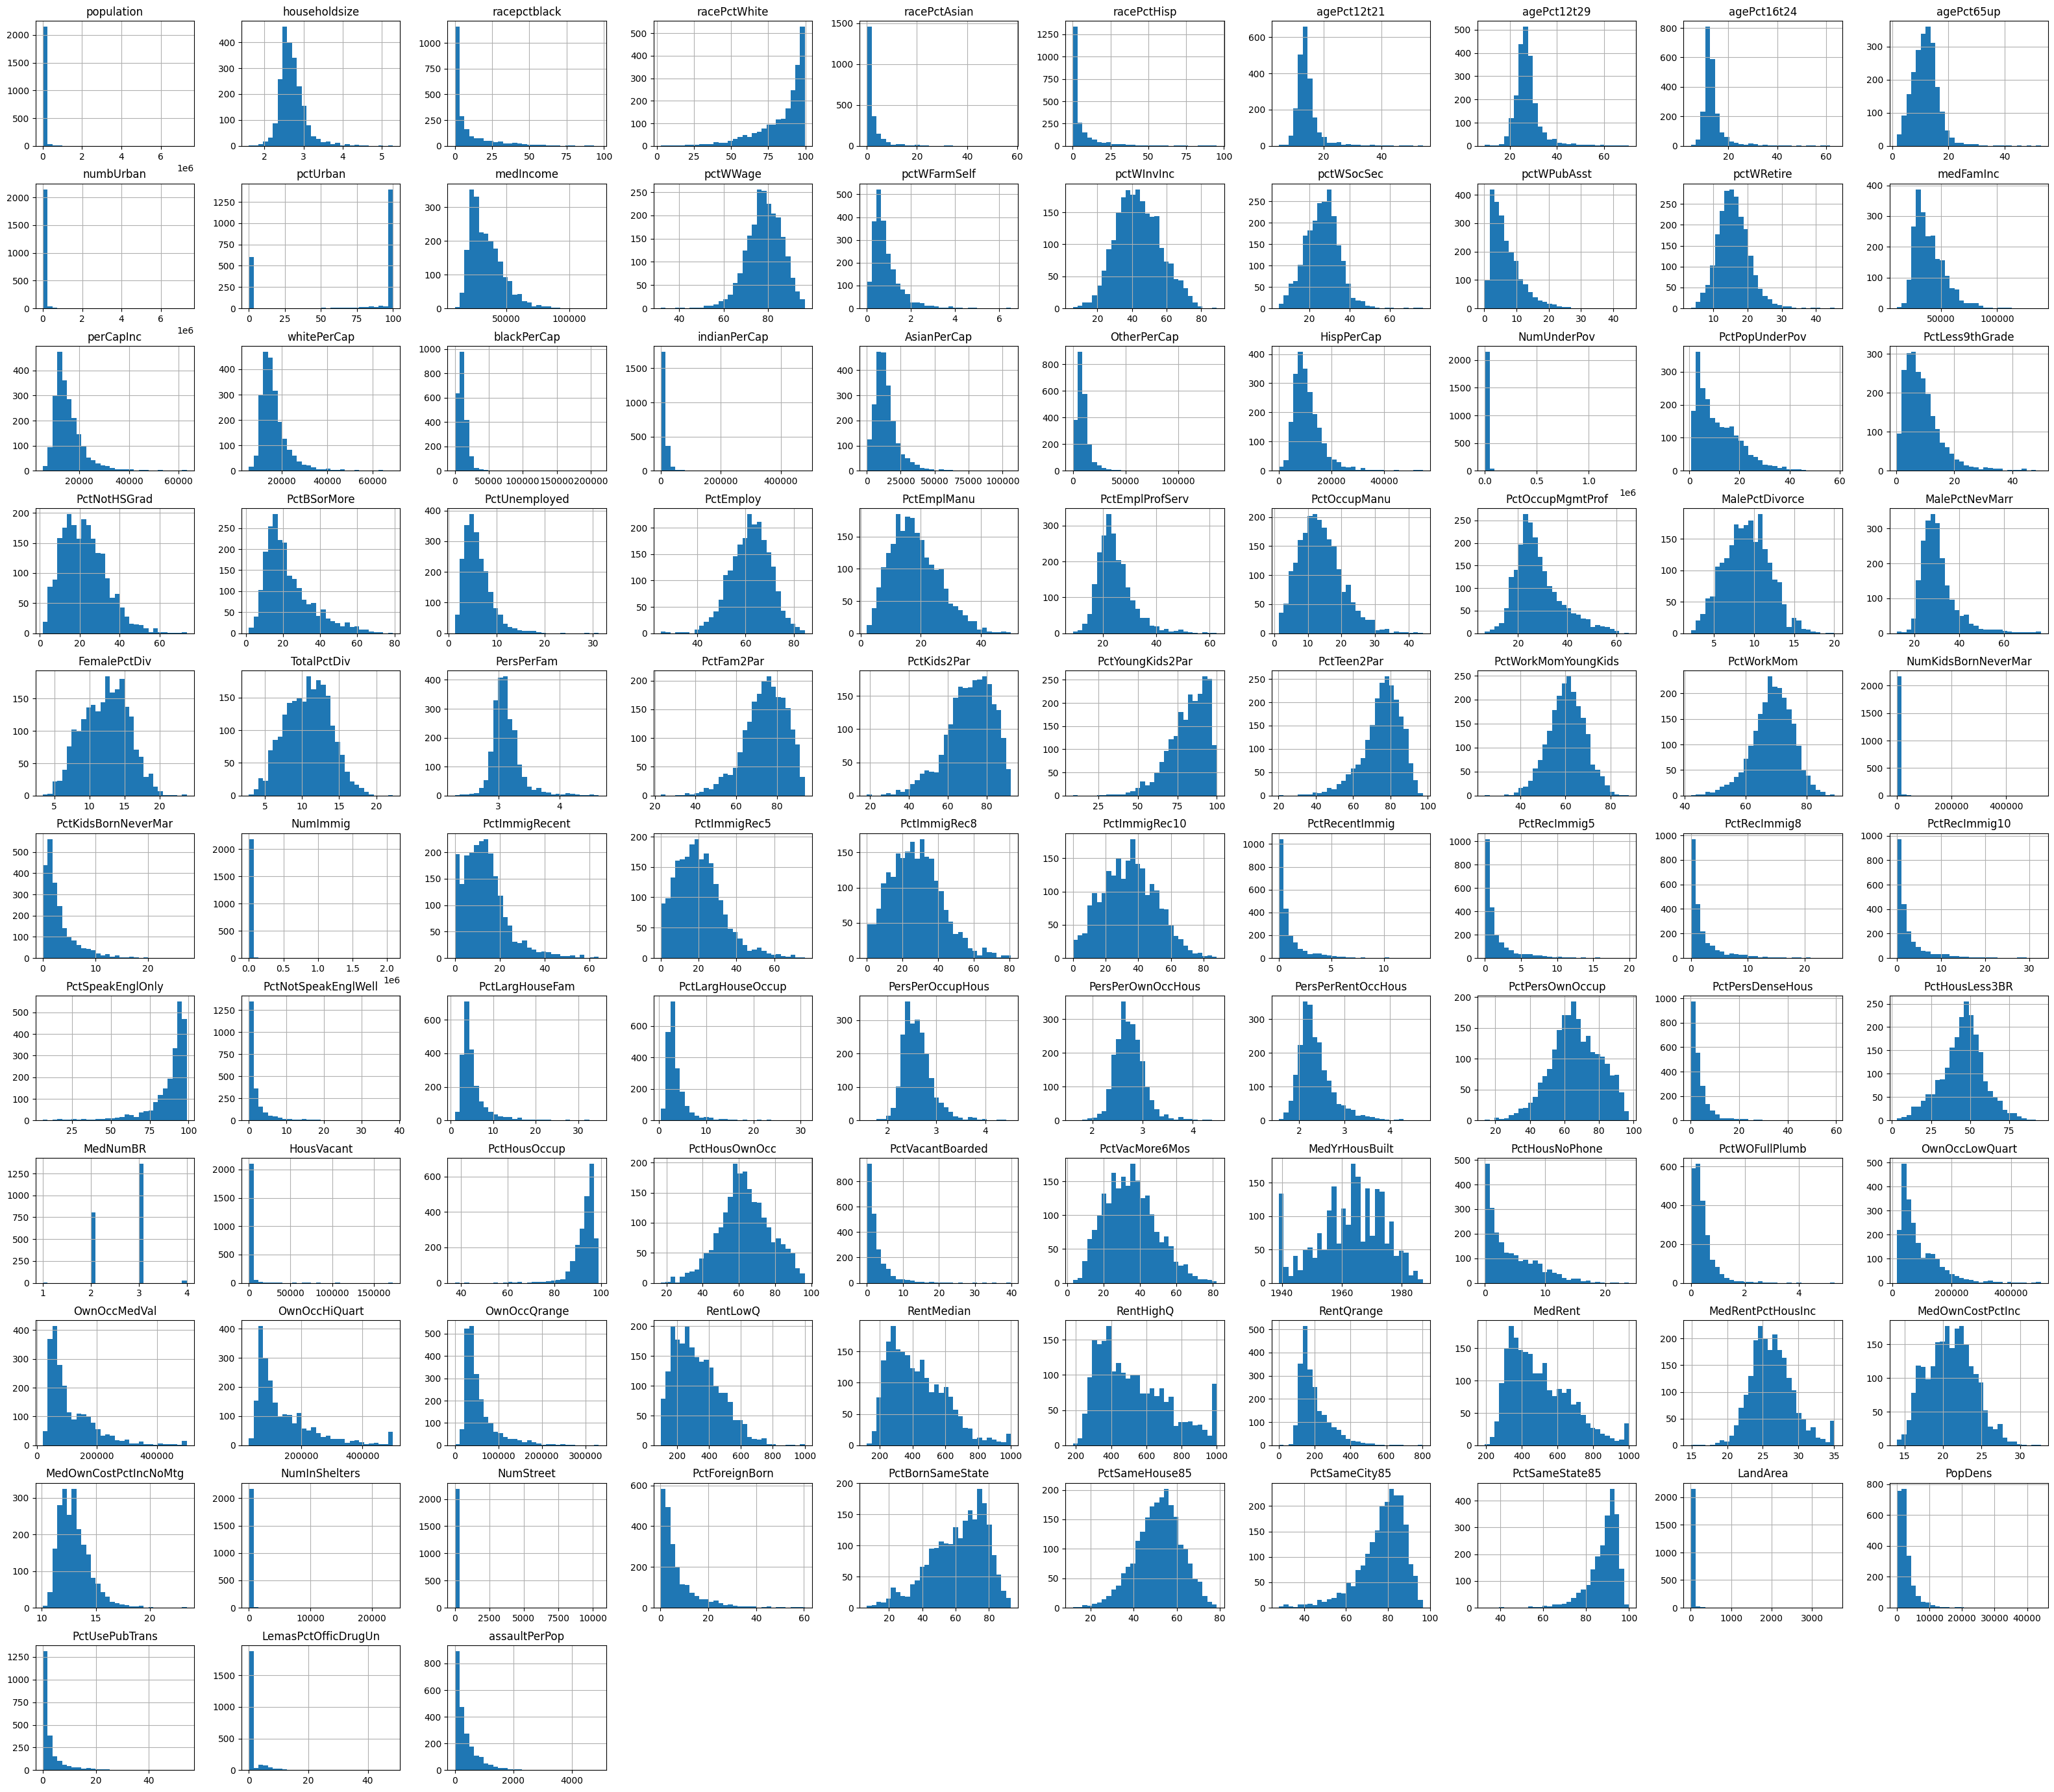

In [9]:
df_cleaned.hist(bins=30, figsize=(40, 35))
plt.show()

As can be seen from the above historgrams, a lot of the features contain outliers. Hence, a standard scaler is chosen to normalize the data since it is less sensitive to outliers. A standard scaler changes the data into standard scores which results in the mean of the feature being 0 and the standard deviation being 1.

In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df_normalized = scaler.fit_transform(df_cleaned)

# Filter Methods